In [1]:
import pandas as pd
import numpy as np
data = {
    "CustomerID": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    "Gender": ["Male", "Male", "Female", "Female", "Female", "Female", "Female", "Female", "Male", "Female",  "Male", "Female", "Female", "Female", "Male", "Male", "Female"],
    "Age": [19, 21, 20, 23, 31, 22, 35, 23, 64, 30, 67, 35, 58, 24, 37, 22, 35],
    "Annual Income (k$)": [15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21],
    "Spending Score (1-100)": [39, 81, 6, 77, 40, 76, 6, 94, 3, 72, 14, 99, 15, 77, 13, 79, 35]
}

df = pd.DataFrame(data)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
categorical_columns = ['Gender']
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ('std', StandardScaler(), numerical_columns),
    ('lab_en', OneHotEncoder(sparse_output=False), categorical_columns)
])

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

wcss = []
K_cluster = range(1, 11)

for k in K_cluster:  # 1 to 10 clusters
    # Build pipeline: preprocess -> KMeans
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])

    # Fit pipeline
    pipeline.fit(df)

    # Extract inertia_ from KMeans step
    inertia = pipeline.named_steps['kmeans'].inertia_
    wcss.append(inertia)

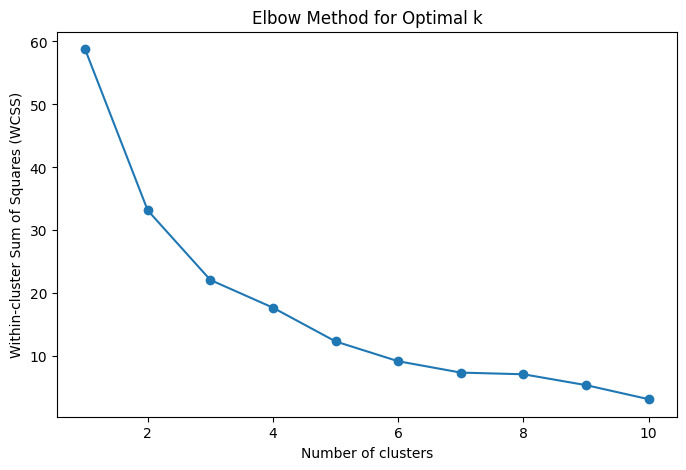

In [5]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [6]:
from kneed import KneeLocator

kneedle = KneeLocator(K_cluster, wcss, curve='convex', direction='decreasing')
optimal_k = kneedle.knee
print("Optimal k found at:", optimal_k)

Optimal k found at: 3


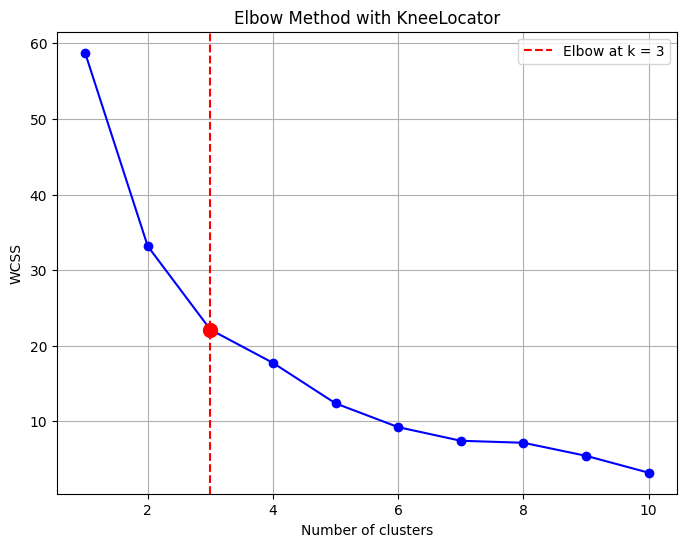

In [7]:
# Optional: Plot with elbow point
plt.figure(figsize=(8, 6))
plt.plot(K_cluster, wcss, 'bo-')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Elbow at k = {optimal_k}')
plt.plot(optimal_k, wcss[optimal_k - 1], 'ro', markersize=10)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method with KneeLocator")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
optimal_k = 3  # Replace with the best k from your elbow plot

final_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('kmeans', KMeans(n_clusters=optimal_k, random_state=42))
])

final_pipeline.fit(df)
df['kmean_Cluster'] = final_pipeline.named_steps['kmeans'].labels_

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns

def plot_clusters_2d(df, cluster_column, title):
    # Transform features with the preprocessor
    X_transformed = preprocessor.transform(df)
    
    # Apply PCA
    X_pca = PCA(n_components=2).fit_transform(X_transformed)
    
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=df[cluster_column],
        palette='tab10',
        s=50,
        legend='full'
    )
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

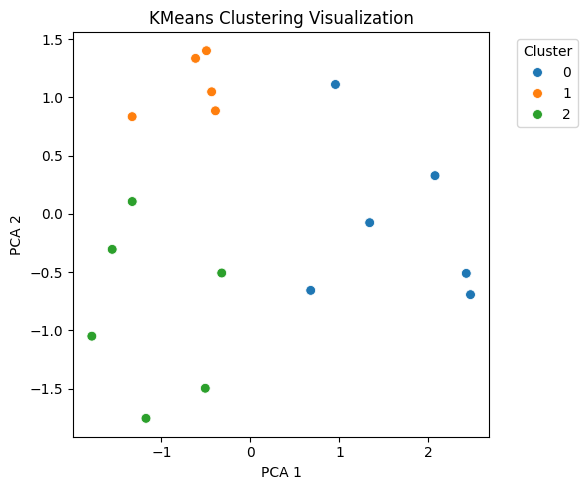

In [13]:
plot_clusters_2d(df, 'kmean_Cluster', 'KMeans Clustering Visualization')

In [14]:
from sklearn.cluster import AgglomerativeClustering

agglo = Pipeline([
    ('preprocess', preprocessor),
    ('agglo', AgglomerativeClustering(n_clusters=4))  # Try with k=4
])

df['Cluster_Agglo'] = agglo.fit_predict(df)

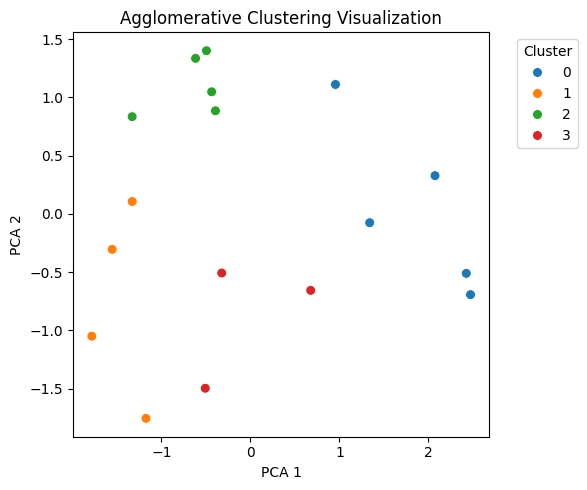

In [15]:
plot_clusters_2d(df, 'Cluster_Agglo', 'Agglomerative Clustering Visualization')

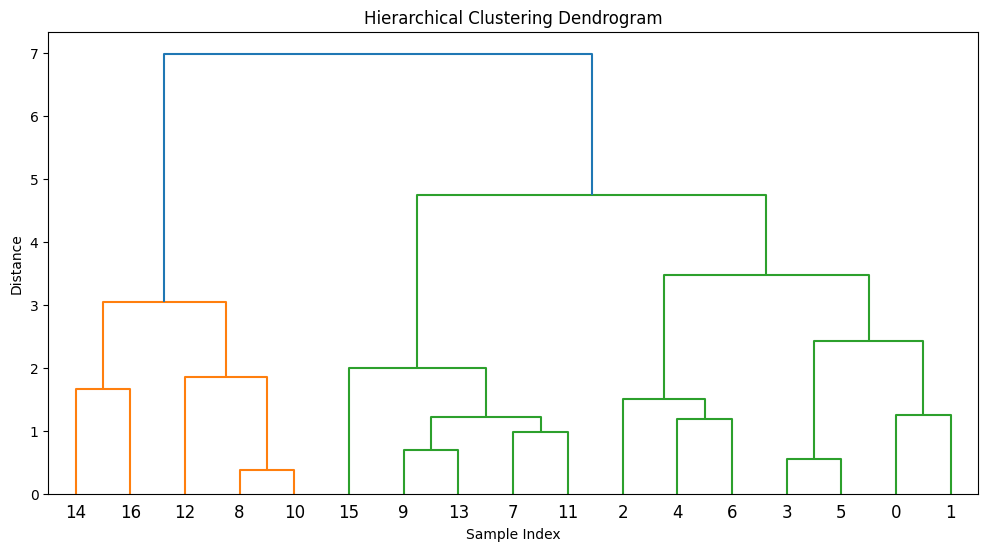

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Use preprocessed data
X_processed = preprocessor.fit_transform(df.drop(columns=['Cluster', 'Cluster_Agglo']))
linked = linkage(X_processed, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [17]:
from sklearn.cluster import DBSCAN

dbscan = Pipeline([
    ('preprocess', preprocessor),
    ('dbscan', DBSCAN(eps=1.5, min_samples=5))  # Tune eps based on data scale
])

df['Cluster_DBSCAN'] = dbscan.fit_predict(df)

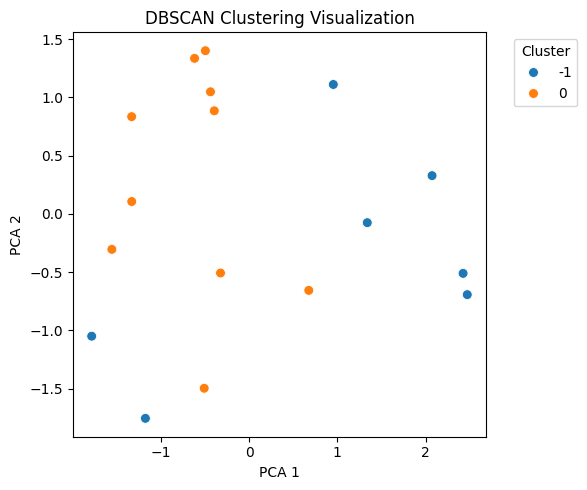

In [18]:
plot_clusters_2d(df, 'Cluster_DBSCAN', 'DBSCAN Clustering Visualization')

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline

gmm = make_pipeline(
    preprocessor,
    GaussianMixture(n_components=4, random_state=42)
)

gmm.fit(df)
df['Cluster_GMM'] = gmm.named_steps['gaussianmixture'].predict(
    preprocessor.transform(df)
)

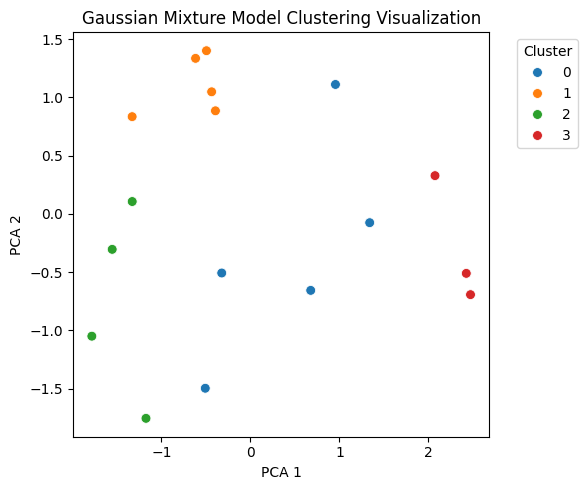

In [20]:
plot_clusters_2d(df, 'Cluster_GMM', 'Gaussian Mixture Model Clustering Visualization')

In [21]:
from sklearn.cluster import OPTICS

optics = Pipeline([
    ('preprocess', preprocessor),
    ('optics', OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05))
])

df['Cluster_OPTICS'] = optics.fit_predict(df)

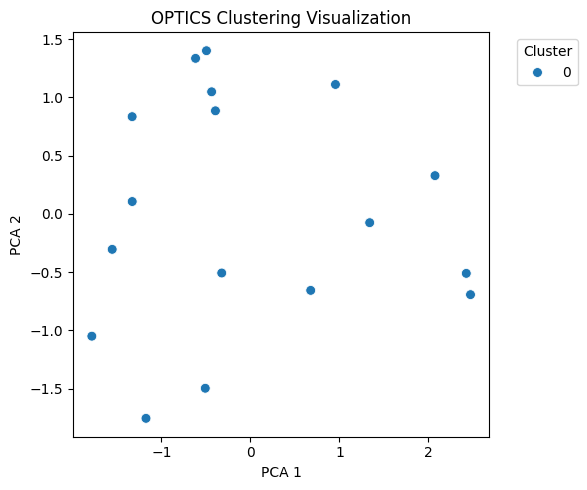

In [22]:
plot_clusters_2d(df, 'Cluster_OPTICS', 'OPTICS Clustering Visualization')

In [23]:
from sklearn.cluster import SpectralClustering

spectral = Pipeline([
    ('preprocess', preprocessor),
    ('spectral', SpectralClustering(n_clusters=4, assign_labels='kmeans', random_state=42))
])

df['Cluster_Spectral'] = spectral.fit_predict(df)

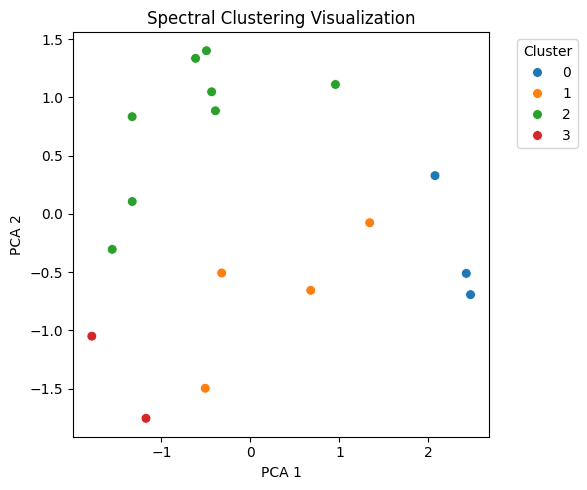

In [24]:
plot_clusters_2d(df, 'Cluster_Spectral', 'Spectral Clustering Visualization')

In [25]:
from sklearn.cluster import MeanShift

meanshift = Pipeline([
    ('preprocess', preprocessor),
    ('meanshift', MeanShift())
])

df['Cluster_MeanShift'] = meanshift.fit_predict(df)

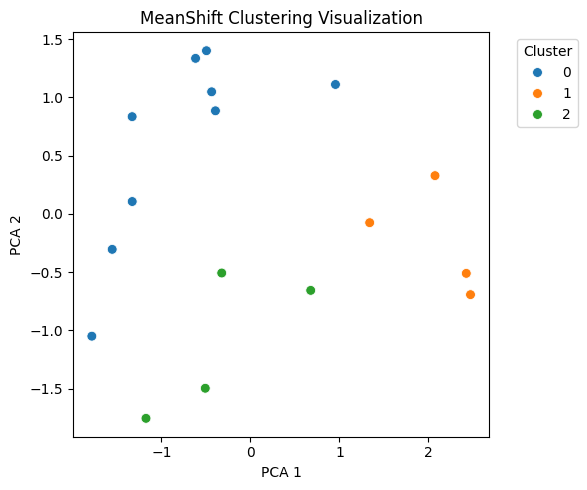

In [26]:
plot_clusters_2d(df, 'Cluster_MeanShift', 'MeanShift Clustering Visualization')

In [27]:
from sklearn.cluster import AffinityPropagation

affinity = Pipeline([
    ('preprocess', preprocessor),
    ('ap', AffinityPropagation(random_state=42))
])

df['Cluster_AP'] = affinity.fit_predict(df)

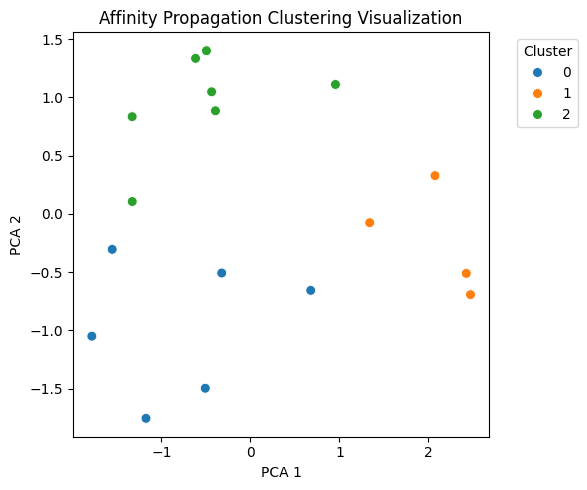

In [28]:
plot_clusters_2d(df, 'Cluster_AP', 'Affinity Propagation Clustering Visualization')

In [29]:
import hdbscan
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


X_transformed = preprocessor.fit_transform(df)
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
df['Cluster_HDBSCAN'] = hdb.fit_predict(X_transformed)

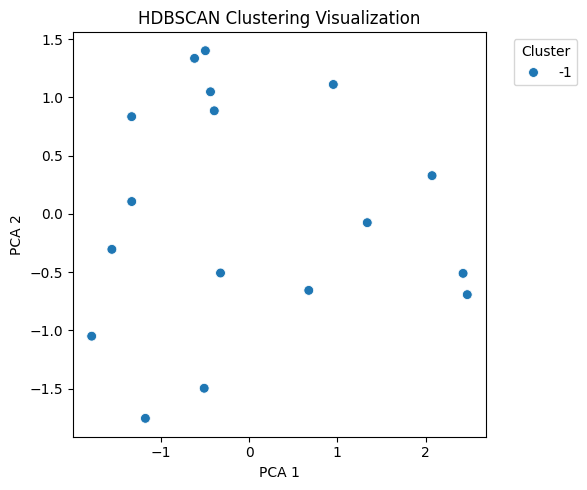

In [30]:
plot_clusters_2d(df, 'Cluster_HDBSCAN', 'HDBSCAN Clustering Visualization')

In [31]:
from sklearn.cluster import Birch

birch = Pipeline([
    ('preprocess', preprocessor),
    ('birch', Birch(n_clusters=4))
])

df['Cluster_Birch'] = birch.fit_predict(df)

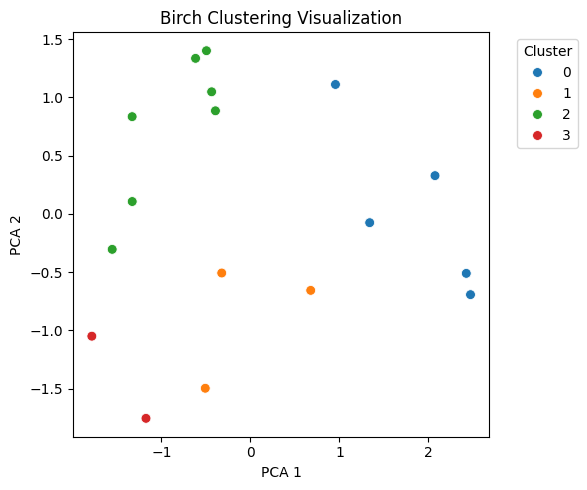

In [32]:
plot_clusters_2d(df, 'Cluster_Birch', 'Birch Clustering Visualization')

In [33]:
from minisom import MiniSom
import numpy as np

X = preprocessor.fit_transform(df)

if hasattr(X, "toarray"):
    X = X.toarray()

som = MiniSom(x=10, y=10, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, 100)

bmu_coordinates = np.array([som.winner(x) for x in X])

bmu_indices = [f"{x[0]}_{x[1]}" for x in bmu_coordinates]

from sklearn.preprocessing import LabelEncoder
cluster_labels = LabelEncoder().fit_transform(bmu_indices)

df['Cluster_SOM'] = cluster_labels

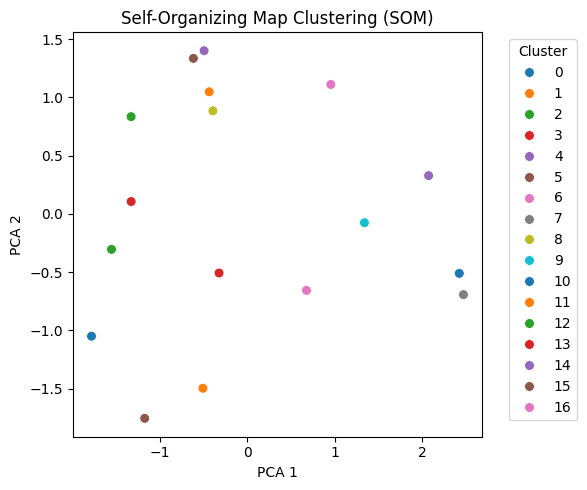

In [34]:
plot_clusters_2d(df, 'Cluster_SOM', 'Self-Organizing Map Clustering (SOM)')

In [35]:
# Step 1: Install if needed
# !pip install pyclustering

from pyclustering.cluster.clarans import clarans
from pyclustering.utils.metric import distance_metric, type_metric

# Step 2: Preprocess the data
X = preprocessor.fit_transform(df)
if hasattr(X, "toarray"):
    X = X.toarray()  # for sparse matrices from OneHotEncoder

# Convert to list format for pyclustering
X_list = X.tolist()

# Step 3: Run CLARANS
clarans_instance = clarans(X_list, number_clusters=4, numlocal=3, maxneighbor=10)
clarans_instance.process()
clusters = clarans_instance.get_clusters()

# Step 4: Convert clusters to full label array
labels = [-1] * len(X_list)
for cluster_id, cluster_indices in enumerate(clusters):
    for index in cluster_indices:
        labels[index] = cluster_id

# Step 5: Add cluster labels to DataFrame
df['Cluster_CLARANS'] = labels

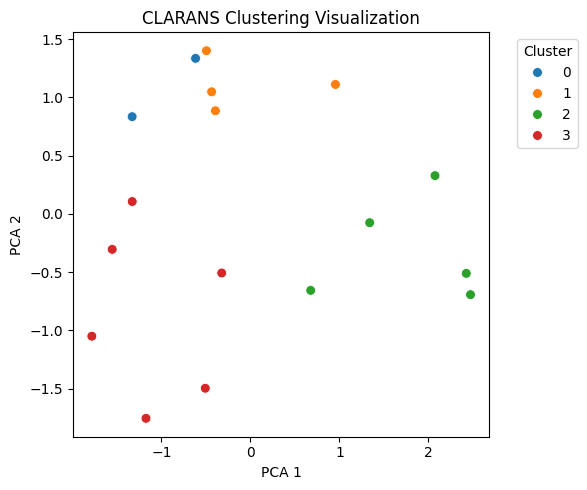

In [36]:
plot_clusters_2d(df, 'Cluster_CLARANS', 'CLARANS Clustering Visualization')

In [37]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
import pandas as pd

def evaluate_clustering(name, model, data, preprocessor):
    # Full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit and predict
    pipeline.fit(data)
    labels = pipeline.named_steps['model'].labels_ if hasattr(pipeline.named_steps['model'], 'labels_') else pipeline.named_steps['model'].predict(preprocessor.transform(data))

    # Transform features only for metric computation
    X_processed = preprocessor.transform(data)

    # Ignore models that return a single cluster
    if len(set(labels)) < 2:
        return {'Model': name, 'Silhouette': None, 'DBI': None, 'CH Index': None}

    return {
        'Model': name,
        'Silhouette': silhouette_score(X_processed, labels),
        'DBI': davies_bouldin_score(X_processed, labels),
        'CH Index': calinski_harabasz_score(X_processed, labels)
    }

In [38]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture

# List of clustering models to evaluate
clustering_algorithms = [
    ('KMeans', KMeans(n_clusters=4, random_state=42)),
    ('Agglomerative', AgglomerativeClustering(n_clusters=4)),
    ('DBSCAN', DBSCAN(eps=1.5, min_samples=5)),
    ('Spectral', SpectralClustering(n_clusters=4, assign_labels='kmeans', random_state=42)),
    ('Birch', Birch(n_clusters=4)),
    ('GMM', GaussianMixture(n_components=4, random_state=42))
]

results = []

for name, model in clustering_algorithms:
    metrics = evaluate_clustering(name, model, df, preprocessor)
    results.append(metrics)

# Display in a DataFrame
metrics_df = pd.DataFrame(results).sort_values(by='Silhouette', ascending=False)
print(metrics_df)

           Model  Silhouette       DBI   CH Index
4          Birch    0.345902  0.796297  10.212316
1  Agglomerative    0.317061  0.896524  10.635898
3       Spectral    0.309777  0.949637   8.997221
0         KMeans    0.290073  0.984158  10.033877
5            GMM    0.290073  0.984158  10.033877
2         DBSCAN    0.212022  1.830730   4.080587


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison(metrics_df):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    # Silhouette
    sns.barplot(data=metrics_df, x='Model', y='Silhouette', hue='Model', palette='crest', ax=axs[0], legend=False)
    axs[0].set_title('Silhouette Score (↑)')
    axs[0].tick_params(axis='x', rotation=45)

    # DBI
    sns.barplot(data=metrics_df, x='Model', y='DBI', hue='Model', palette='flare', ax=axs[1], legend=False)
    axs[1].set_title('Davies-Bouldin Index (↓)')
    axs[1].tick_params(axis='x', rotation=45)

    # CH Index
    sns.barplot(data=metrics_df, x='Model', y='CH Index', hue='Model', palette='viridis', ax=axs[2], legend=False)
    axs[2].set_title('Calinski-Harabasz Index (↑)')
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

Skipping Cluster_OPTICS: only one cluster or all noise.
Skipping Cluster_HDBSCAN: only one cluster or all noise.
Skipping Cluster_SOM: Number of labels is 17. Valid values are 2 to n_samples - 1 (inclusive)


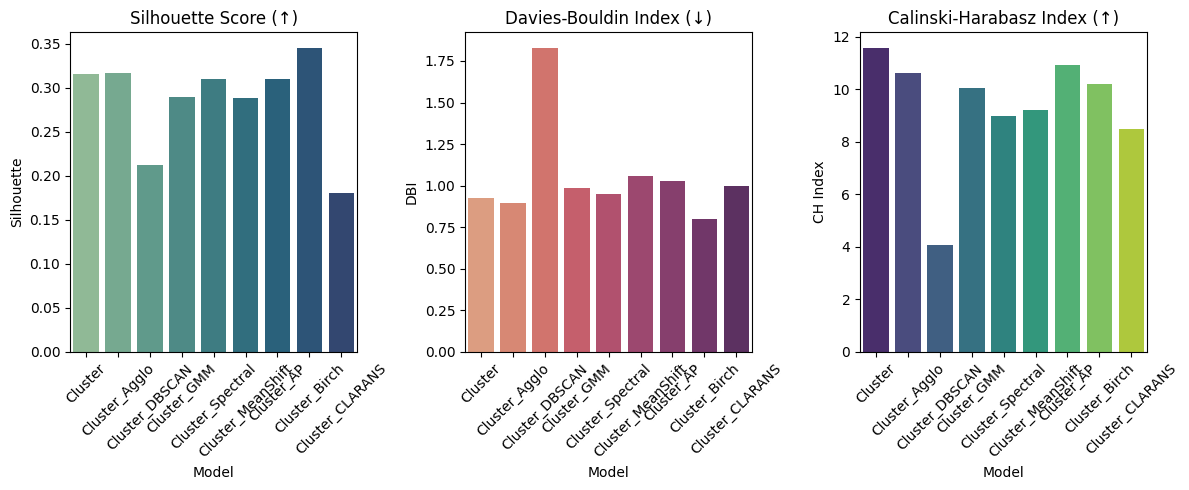

In [40]:
# Step 1: Preprocess the data
X = preprocessor.fit_transform(df)
if hasattr(X, "toarray"):  # handle sparse matrix
    X = X.toarray()

# Step 2: Update cluster_columns list to include SOM and CLARANS
cluster_columns = [
    'Cluster', 'Cluster_Agglo', 'Cluster_DBSCAN', 'Cluster_GMM', 
    'Cluster_OPTICS', 'Cluster_Spectral', 'Cluster_MeanShift', 
    'Cluster_AP', 'Cluster_HDBSCAN', 'Cluster_Birch',
    'Cluster_SOM', 'Cluster_CLARANS'  # newly added clustering methods
]

# Step 3: Initialize metrics container
metrics = []

# Step 4: Loop over each clustering method
for col in cluster_columns:
    if col not in df.columns:
        print(f"Skipping {col}: column not found in DataFrame.")
        continue
    
    labels = df[col]
    
    # Skip if only 1 cluster or all noise
    if len(set(labels)) <= 1 or (labels == -1).all():
        print(f"Skipping {col}: only one cluster or all noise.")
        continue
    
    try:
        silhouette = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        ch_index = calinski_harabasz_score(X, labels)

        metrics.append({
            'Model': col,
            'Silhouette': silhouette,
            'DBI': dbi,
            'CH Index': ch_index
        })
    except Exception as e:
        print(f"Skipping {col}: {e}")

# Step 5: Create a DataFrame from the results
metrics_df = pd.DataFrame(metrics)

# Step 6: Visualize
plot_comparison(metrics_df)

```python
# Install with: pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

kmedoids = Pipeline([
    ('preprocess', preprocessor),
    ('kmedoids', KMedoids(n_clusters=4, random_state=42))
])

df['Cluster_KMedoids'] = kmedoids.fit_predict(df)
```